In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Load All Pram Sold Data

In [2]:
df = pd.read_json('../../data/kapiti_sold.json')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype              
---  ------                                --------------  -----              
 0   property_id                           728 non-null    object             
 1   date                                  728 non-null    datetime64[ns, UTC]
 2   price                                 645 non-null    float64            
 3   sales_count                           728 non-null    int64              
 4   url                                   728 non-null    object             
 5   address                               728 non-null    object             
 6   street                                728 non-null    object             
 7   street_number                         728 non-null    int64              
 8   suburb                                719 non-null    object             
 9   solar                

## Replace url with the real url

In [4]:
df['url'] = df['url'].apply(lambda x: f"https://homes.co.nz/address{x}")

In [5]:
df['date_month'] = pd.to_datetime(df['date']).dt.to_period('M')

/var/folders/rk/1bwp3kk16sl5nkdqkxc9rj1h0000gn/T/ipykernel_4305/1362257986.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['date_month'] = pd.to_datetime(df['date']).dt.to_period('M')


## Show the data with duplicated address and only keep the highest price one

In [6]:
df.loc[df.duplicated(subset=['address'], keep=False), ['address','date_month', 'price', 'url', 'decade_built']]

,address,date_month,price,url,decade_built
373,"25 Hollis Rd, Paraparaumu Beach, Paraparaumu",2023-02,550000.0,https://homes.co.nz/address/paraparaumu/parapa...,1970.0
448,"25 Hollis Rd, Paraparaumu Beach, Paraparaumu",2022-12,510000.0,https://homes.co.nz/address/paraparaumu/parapa...,1970.0
473,"72 Rimu Road, Raumati Beach, Paraparaumu",2022-12,476000.0,https://homes.co.nz/address/paraparaumu/raumat...,1990.0
474,"72 Rimu Road, Raumati Beach, Paraparaumu",2022-12,500000.0,https://homes.co.nz/address/paraparaumu/raumat...,1990.0
516,"72 Rimu Road, Raumati Beach, Paraparaumu",2022-11,440000.0,https://homes.co.nz/address/paraparaumu/raumat...,1990.0
686,"57 Mazengarb Road, Paraparaumu Beach, Paraparaumu",2022-09,NaN,https://homes.co.nz/address/paraparaumu/parapa...,1970.0
720,"57 Mazengarb Road, Paraparaumu Beach, Paraparaumu",2022-08,681000.0,https://homes.co.nz/address/paraparaumu/parapa...,1970.0


In [7]:
df.sort_values(by=['price'], ascending=False, inplace=True)
df.drop_duplicates(subset=['address'], keep='first', inplace=True)

## Show Missing Data

In [8]:
#msno.bar(df)

In [9]:
df.isna().sum().sort_values(ascending=False)

solar                                   94
price                                   82
display_estimated_rental_lower_value    60
display_estimated_rental_upper_value    60
decade_built                            45
bed_estimate                            21
bath_estimate                           21
suburb                                   9
display_estimated_upper_value            0
agent                                    0
has_deck                                 0
land_area                                0
floor_area                               0
num_car_spaces                           0
estimated_rental_yield                   0
property_id                              0
display_estimated_lower_value            0
date                                     0
improvement_value                        0
land_value                               0
capital_value                            0
street_number                            0
street                                   0
address    

In [10]:
# Fill Missing Price Data with its mean value
#df['price'] = df['price'].replace(0, np.nan)
#df['price'] = df['price'].fillna(df['price'].mean())

## Display the data with missing price

In [11]:
df.loc[df['price'].isna(), ['address', 'capital_value', 'land_value', 'improvement_value', 'display_estimated_lower_value','display_estimated_lower_value', 'url']]

,address,capital_value,land_value,improvement_value,display_estimated_lower_value,display_estimated_lower_value,url
0,"10 Leanne Way, Waikanae Beach, Waikanae",730000,315000,415000,765000,765000,https://homes.co.nz/address/waikanae/waikanae-...
1,"7 Lorna Irene Drive, Raumati South, Paraparaumu",770000,370000,400000,825000,825000,https://homes.co.nz/address/paraparaumu/raumat...
2,"1C/25 Maclean Street, Paraparaumu Beach, Parap...",420000,185000,235000,390000,390000,https://homes.co.nz/address/paraparaumu/parapa...
3,"64B Matatua Road, Raumati Beach, Paraparaumu",610000,255000,355000,650000,650000,https://homes.co.nz/address/paraparaumu/raumat...
4,"5 Sovereign Way, Paraparaumu",910000,450000,460000,985000,985000,https://homes.co.nz/address/paraparaumu/parapa...
...,...,...,...,...,...,...,...
624,"2 Sydney Crescent, Raumati South, Paraparaumu",840000,265000,575000,935000,935000,https://homes.co.nz/address/paraparaumu/raumat...
626,"189 Tutere Street, Waikanae Beach, Waikanae",890000,570000,320000,955000,955000,https://homes.co.nz/address/waikanae/waikanae-...
638,"3 Trinity Place, Paraparaumu Beach, Paraparaumu",670000,360000,310000,725000,725000,https://homes.co.nz/address/paraparaumu/parapa...
659,"17 Nathan Avenue, Paraparaumu Beach, Paraparaumu",670000,530000,140000,705000,705000,https://homes.co.nz/address/paraparaumu/parapa...


## Drop price if missing

In [12]:
df['price'] = df['price'].replace(0, np.nan)
df.dropna(subset = ['price'], inplace=True)

## calculate the average price group by suburb

<Axes: xlabel='suburb'>

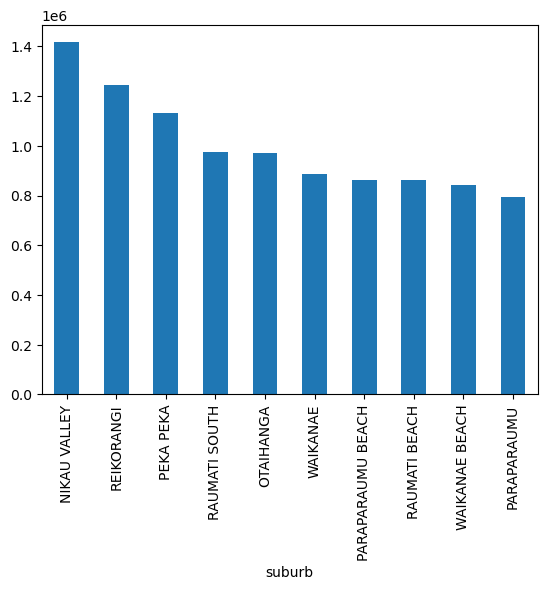

In [13]:
df.groupby(['suburb'])['price'].mean().sort_values(ascending=False).plot(kind='bar')


## Sales by month

<Axes: xlabel='date_month'>

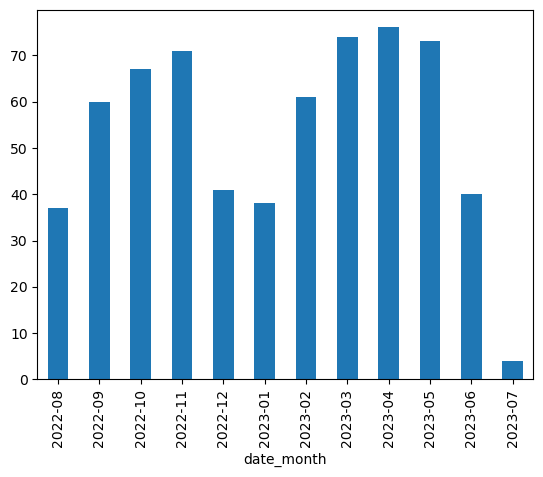

In [14]:
df.groupby(['date_month'])['date_month'].count().plot(kind='bar')

## Correlation of price

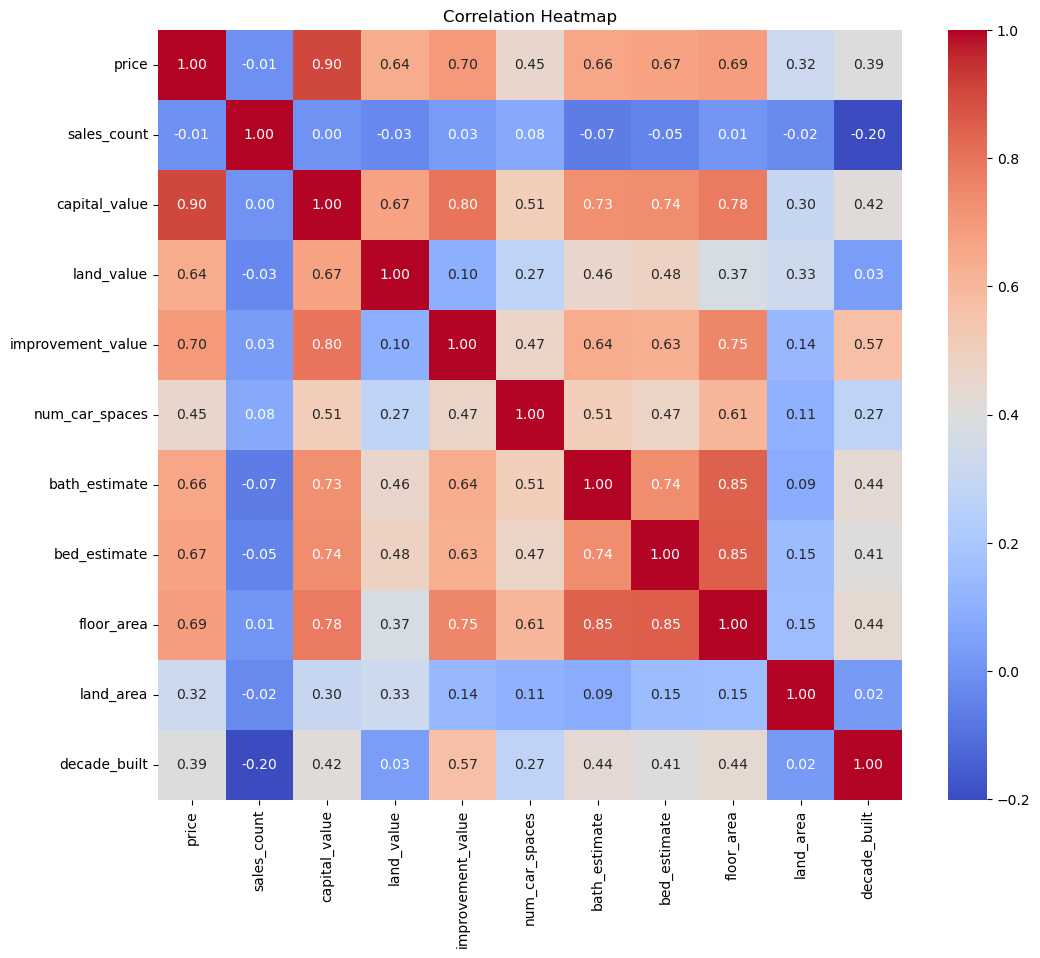

In [15]:
columns_of_interest = ['price',
                       'sales_count',
                       'capital_value',
                       'land_value',
                       'improvement_value',
                       'num_car_spaces',
                       'bath_estimate',
                       'bed_estimate',
                       'floor_area',
                       'land_area',
                       'decade_built'
                       ]
correlation_matrix = df[columns_of_interest].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


## calculate percentage of (price - capital_value) / capital_value

<Axes: xlabel='suburb'>

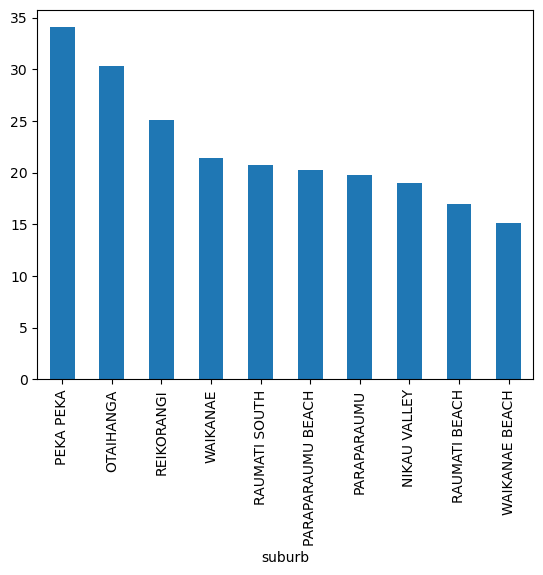

In [16]:
df['exceed_cv_percentage'] = (df['price'] - df['capital_value']) * 100 / df['capital_value']

## calculate the average exceed CV percentage group by suburb
df.groupby(['suburb'])['exceed_cv_percentage'].mean().sort_values(ascending=False).plot(kind='bar')


In [17]:
# Group data by suburb and calculate relevant statistics
grouped_data = df.groupby('suburb').agg({
    'property_id': 'count',
    'price': ['mean', 'min', 'max'],
    'sales_count': 'sum',
    'floor_area': 'mean',
    'land_area': 'mean'
}).reset_index()

# Rename the columns for better readability
grouped_data.columns = ['Suburb', 'Number of Sales', 'Average Price', 'Min Price', 'Max Price',
                        'Total Sales Count', 'Average Floor Area', 'Average Land Area']


# Calculate price per square meter
grouped_data['Price per sqm'] = grouped_data['Average Price'] / grouped_data['Average Floor Area']

# Sort by price per square meter
grouped_data_sorted = grouped_data.sort_values(by='Price per sqm')

# Calculate the average decade built for each suburb
average_decade_built = df.groupby('suburb')['decade_built'].mean().reset_index()

# Merge the average decade built with the grouped data
merged_data = pd.merge(grouped_data_sorted, average_decade_built, left_on='Suburb', right_on='suburb')

print(merged_data)


              Suburb  Number of Sales  Average Price  Min Price  Max Price  \
0        PARAPARAUMU              139   7.958357e+05   440000.0  1500000.0   
1  PARAPARAUMU BEACH              142   8.632402e+05   300000.0  2100000.0   
2      RAUMATI BEACH               83   8.617187e+05   390000.0  2200000.0   
3           WAIKANAE              160   8.884705e+05   378500.0  2651000.0   
4       NIKAU VALLEY                4   1.416250e+06  1200000.0  1890000.0   
5     WAIKANAE BEACH               51   8.437461e+05   440500.0  1495000.0   
6      RAUMATI SOUTH               36   9.755304e+05   520000.0  2090000.0   
7          OTAIHANGA               11   9.700000e+05   650000.0  3000000.0   
8         REIKORANGI                3   1.243333e+06   925000.0  1625000.0   
9          PEKA PEKA                4   1.130250e+06  1010000.0  1211000.0   

   Total Sales Count  Average Floor Area  Average Land Area  Price per sqm  \
0                561          154.086331         931.683453    

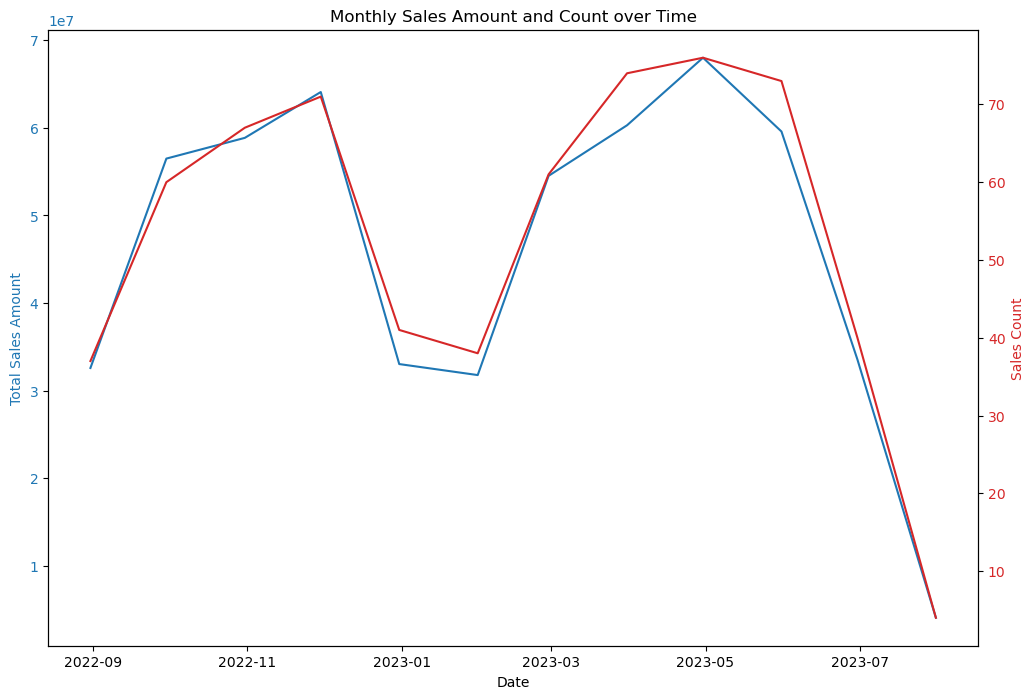

In [18]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Resample the data by month and calculate the total sales amount and sales count for each month
monthly_sales_stats = df.resample('M', on='date').agg({
    'price': ['sum', 'count']
})

# Plot the total sales amount and sales count over time
fig, ax1 = plt.subplots(figsize=(12, 8))

# Make the first plot: total sales amount
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales Amount', color=color)
ax1.plot(monthly_sales_stats.index, monthly_sales_stats[('price', 'sum')], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the sales count
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Sales Count', color=color)
ax2.plot(monthly_sales_stats.index, monthly_sales_stats[('price', 'count')], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set the title and show the plot
plt.title('Monthly Sales Amount and Count over Time')
plt.show()


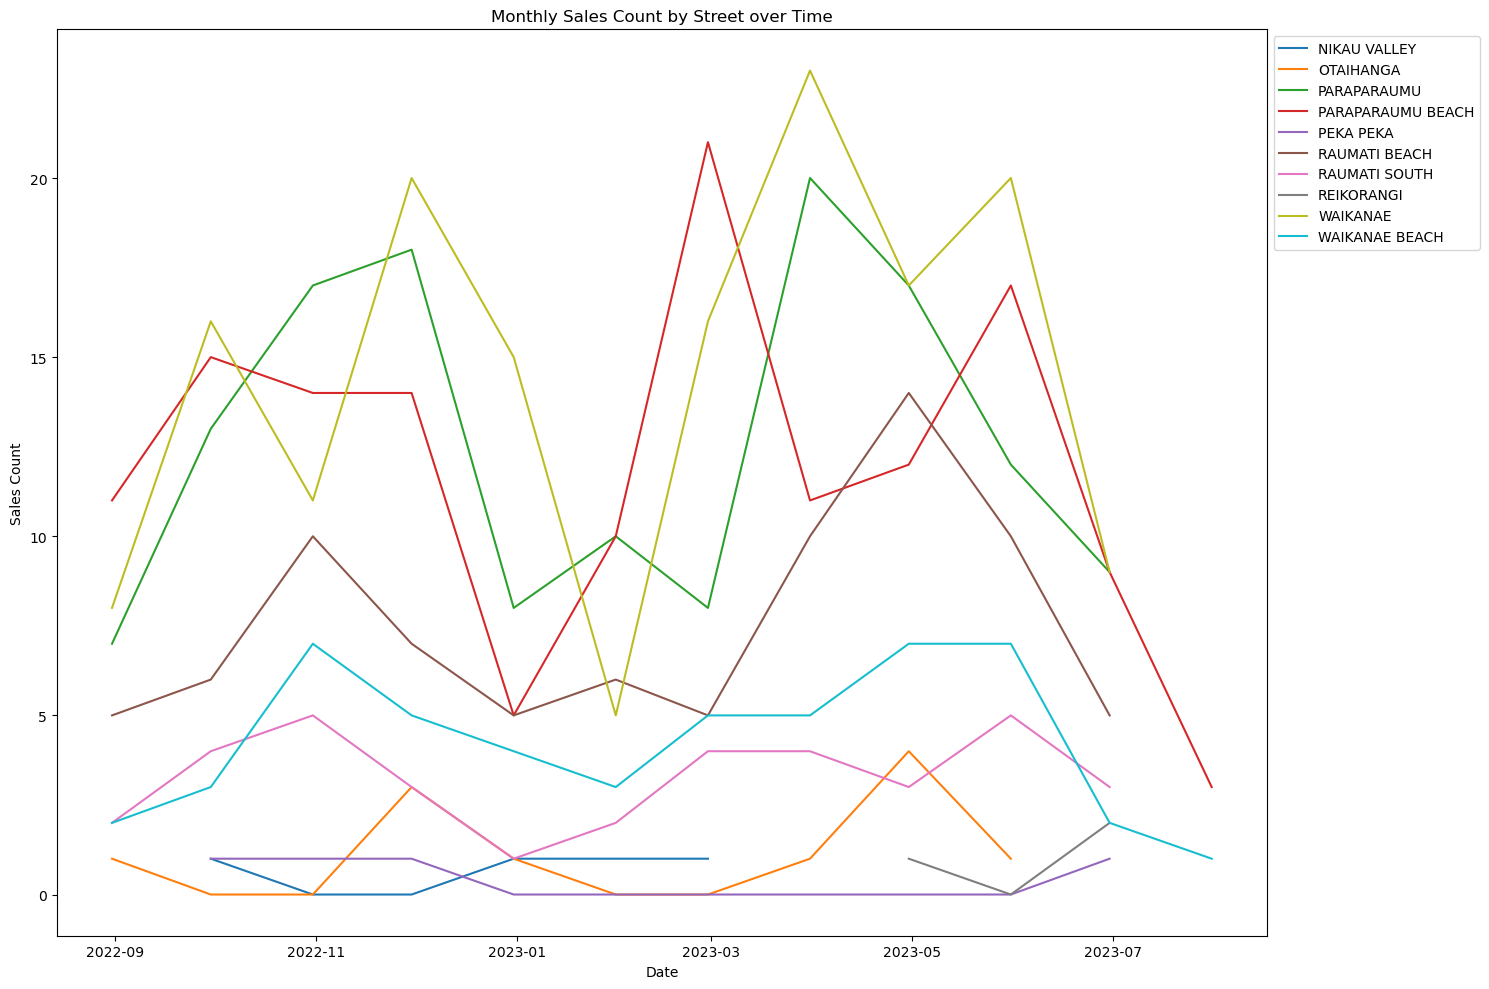

In [19]:
# Resample the data by month and street, then count the number of sales for each combination
monthly_sales_by_street = df.groupby(['suburb']).resample('M', on='date').size().unstack(0)

# Plot the sales count for each street over time
plt.figure(figsize=(15, 10))
for street in monthly_sales_by_street.columns:
    plt.plot(monthly_sales_by_street.index, monthly_sales_by_street[street], label=street)

plt.title('Monthly Sales Count by Street over Time')
plt.xlabel('Date')
plt.ylabel('Sales Count')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()